#⚙️ Welcome to the Game Recording Data Processor ⚙️

This notebook is purpose built to process the recordings generated from the **Autonomous Game Player Framework** to create ready to use training data for our models. 🏋️

In breif, the Autonomous Game Player Framework is a set of python files that allows you to create recordings of yourself playing a game on your computer, then using those recordings to train a model, then after a model has been trained, execute that model in the framework to watch it autonomously play the game. 🤖

This notebook is solely for the purpose of preproccessing the data so that we can train with it in a separate notebook. This notebook was designed to create the training data for a driving game. By the end of the notebook we will have gone from the raw recordings, to training examples, to batched files.

Let's get into it!!

### Imports

In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import os
import time
import gc
from multiprocessing import Pool

### Configure

In [2]:
recordings_dir = '/content/drive/MyDrive/Projects/AutonomousGamePlayer/RallyRacerDirtRecordings'
examples_dir = '/content/drive/MyDrive/Projects/AutonomousGamePlayer/Examples'
batched_examples_dir = '/content/drive/MyDrive/Projects/AutonomousGamePlayer/BatchedExamples'
window_size = 20
step_size = 1
batch_size = 32
np.random.seed(69)

# The Recordings

To start, we'll have a look at a single recording outputed from the framework. A recording is simply a pickle file containing a dictionary with the keys `screen_frames` and `key_frames`. `screen_frames` is the array containing the sequence of images recorded as you played the game and `key_frames` is the array of recorded key states at each timestep of the recording. A `1` in the key state array denotes that a key was pressed and a `0` denotes that the key was not pressed. Each key that was recorded has it's own index in the array to record it's state. In the following recordings the order of keys is in a key state is [⬆️, ⬅️, ➡️, ⬇️]

### Get the list of pickle files in a directory

In [3]:
def get_pickle_file_paths(dir):
  """
  Gets the list of pickle files in a directory
  ARGS:
    dir (string): Directory
  RETURNS:
    file_names (list): List of file names
  """
  file_names = []
  for filename in os.listdir(dir):
    if filename.endswith('.pickle'):
      path = os.path.join(dir, filename)
      file_names.append(path)
  return file_names

In [4]:
# Get the recording file paths from the recordings dir
recording_file_paths = get_pickle_file_paths(recordings_dir)

In [5]:
print(f'Number of files: {len(recording_file_paths)}')

Number of files: 3


### Load a pickle object

In [6]:
def load_pickle_object(file_path):
  """
  Loads and returns the object from a pickle file
  ARGS:
    file_path (string): File path
  RETURNS:
    object (dict): the pickled object
  """
  # Open file
  with open(file_path, 'rb') as handle:
    # Load data
    pickle_object = pickle.load(handle)
    return pickle_object

### Save a pickle object

In [7]:
def save_pickle_object(object, file_name):
  """
  Saves a pickle object
  ARGS:
    object (dict): the pickled object
    file_name (string): File name
  """
  # Open file
  with open(file_name, 'wb') as handle:
    # Save data
    pickle.dump(object, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# As an example, load the a recording object
recording = load_pickle_object(recording_file_paths[1])

# Print the objects keys
print(recording.keys())

dict_keys(['key_frames', 'screen_frames'])


In [9]:
# Print the shapes of screen_frames and key_frames
print(f"Screen Frames Shape: {recording['screen_frames'].shape}")
print(f"Key Frames Shape: {recording['key_frames'].shape}")

Screen Frames Shape: (478, 256, 256, 3)
Key Frames Shape: (478, 4)


### Shapes

In this particular example the shapes in the first recording were as follows...

`389` being the number of frames recorded

`256, 256, 3` being the RGB images

`4` being the number of keys in a key state. In this case the 4 keys in a key state being ⬆️ ⬅️ ➡️ ⬇️ in that order




# Let's have a look at the recording

### Display Images Function

In [10]:
def display_images(
    images,
    labels=None,
    label_title='Label',
    prediction_labels=None,
    prediction_label_title='Prediction',
    n=10,
    random=False
    ):
  """
  Displays a list of images
  ARGS:
    images (list): List of images
    labels (list, optional): List of labels
    label_title (string, optional): Label title
    prediction_labels (list, optional): List of prediction labels
    prediction_label_title (string, optional): Prediction label title
    n (int, optional): Number of images to display
    random (bool, optional): Whether to randomize
  """
  # If random
  if random:
    random_indices = np.random.choice(len(images), n)
    images = images[random_indices]
    if labels is not None:
      labels = labels[random_indices]
    if prediction_labels is not None:
      prediction_labels = prediction_labels[random_indices]

  # n images and labels
  images = images[:n]
  if labels is not None:
    labels = labels[:n]
  if prediction_labels is not None:
    prediction_labels = prediction_labels[:n]

  # Normalize
  if images.max() > 1.0:
    images = images / 255.0

  # Rows and columns
  columns = 5
  rows = len(images) // columns + 1 if len(images) % columns != 0 else len(images) // columns

  # Plot width and height
  width = 15
  height = 4 * rows

  # Create figure and axes
  fig, axes = plt.subplots(rows, columns, figsize=(width, height))

  # Loop over plots
  for i, ax in enumerate(axes.flat):
    # Hide axis
    ax.set_xticks([])
    ax.set_yticks([])
    # Skip if no image
    if i >= len(images):
      continue
    # Set title
    title = ''
    if labels is not None:
      title += f'{label_title}: {labels[i]}\n'
    if prediction_labels is not None:
      title += f'{prediction_label_title}: {prediction_labels[i]}'
    ax.set_title(title)
    # Show image
    ax.imshow(images[i])


  plt.show()

### Show recording

In [11]:
def show_recording(recording, start_frame=0, n=20):
  """
  Displays a recording
  ARGS:
    recording (dict): Recording
    start_frame (int, optional): Start frame
    n (int, optional): Number of frames to display
  """
  key_frames = [str(key_frame) for key_frame in recording['key_frames'][start_frame:start_frame+n]]
  screen_frames = recording['screen_frames'][start_frame:start_frame+n]
  display_images(screen_frames, labels=key_frames, label_title='Key Frame', n=n)

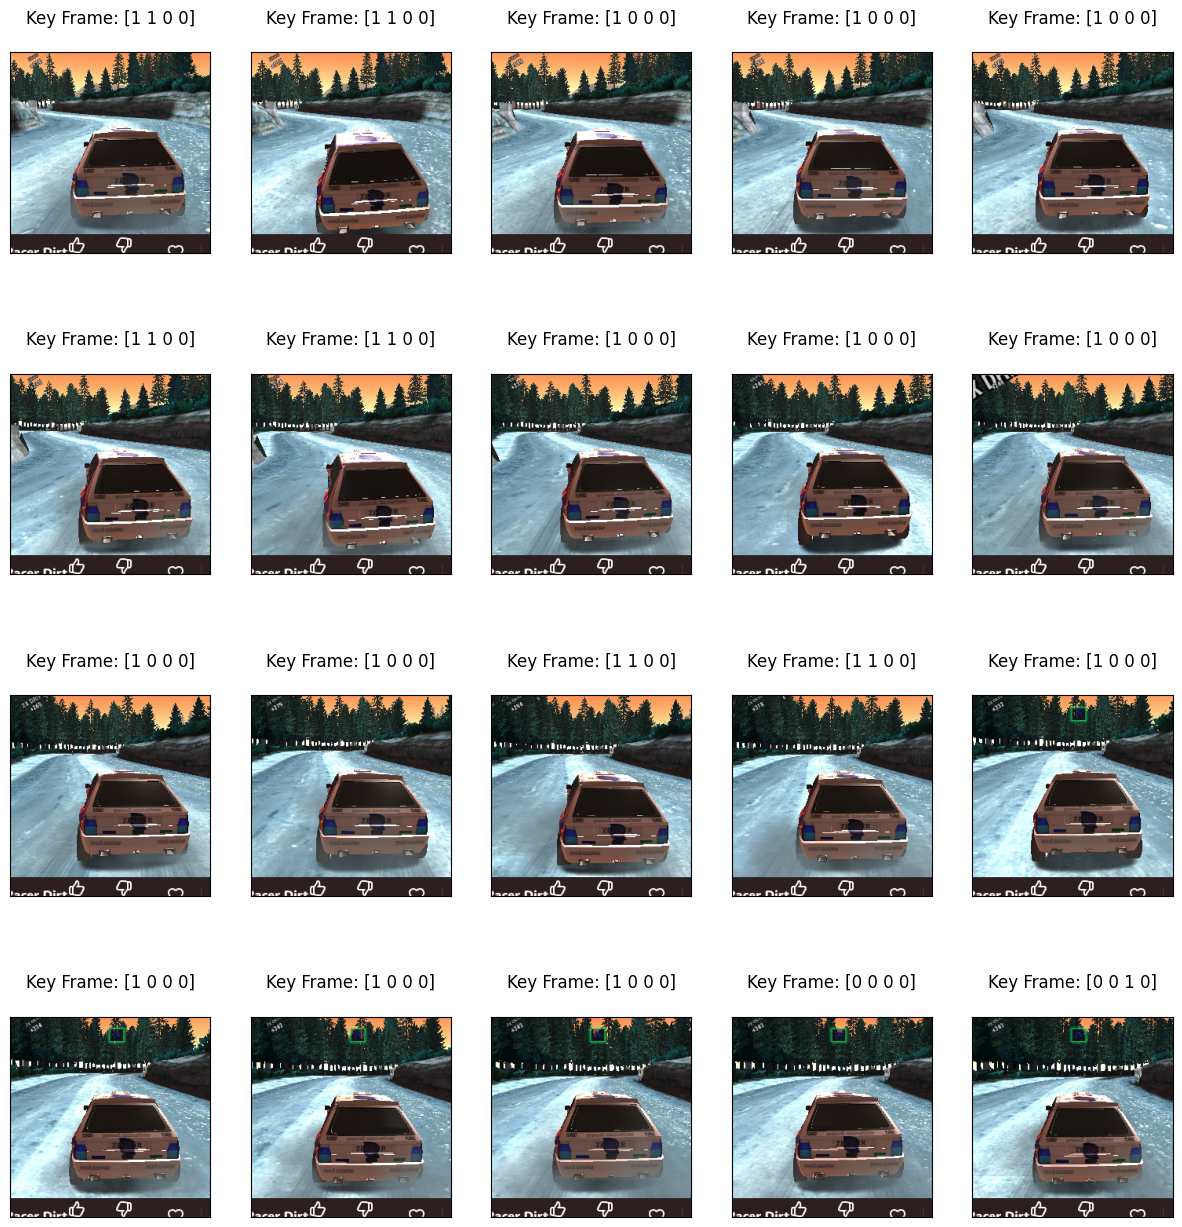

In [12]:
show_recording(recording, start_frame=105, n=20)

In this recording we can see the images and key states from left to right, top to bottom, that play the movie of this section of the recording. The key states above each image show which keys were pressed or not at that time step. In this example we see me driving around a left corner, initiating a drift and gassing through it.

# Imitation Learning

Although there are many different ways that you can create a model predict a correct action given some environment, we will use a techniqe known as Imitation Learning to train our model to behave as we would given the same environment. This approach turns the problem into a simple supervised learning problem with the input being the image frames and the output beeing the key state. The idea is if that if we can controll the vehicle succesfully from visual data alone, we can train a model to imitate these controls based off of the the images that it sees.

# Inputs and Outputs

The state that the recordings are in right now aren't ready be trained on. We have to do some transformations on the data first so that we can pass it through a model. So let's define what our inputs and outputs will be.

###Input
When we play a game we use the visual data from the screen to decide what keys to press and when. The model should also use the same visual input to determing what actions it should take. But since a single frame probably isn't enough for a model to make an informed decision we will pass it a set amount of previous frames for it to concider to making it's prediction. We will call the amount of previous frames the `window size` and pass that many image frames to the model to produce an output. In my case I found that a reasonable window size to be 20 frames. Or in other words, if the frames were taken at 10 fps, 2 seconds of video data.

###Output
In order for the to model drive itself we need to continuosly make inferences on it so that it can generate the next action to take. The framework is designed to make an inference on the model every time there is a new image available. So we will pass a sliding window of images to the model to decide which action to take. Actions in this case is the key state of which keys should be pressed or not pressed. For example if the model sees an open road ahead it should probably press ⬆️ and not press ⬅️, ➡️, or ⬇️. So the output array should be `[1, 0, 0, 0]`. Similarly if the model see's a left turn, it should probably be pressing ⬅️, resulting in an output array of `[0, 1, 0, 0]`.
However, becuase its also possible and likely that we'll press multiple keys at once we will treat our model as a multi-class multi-lable classifier.


# Segmentation

Now we can move onto segmenting our recordings into examples that we can use to train our model. The following methods wrap the logic of segmenting the recording, creating examples from those segments and indexing those examples.

A single example will made by taking the screen and key frame segments, using the video frames as the input or $X$ variable and the last key state of the key state frames as the output or $y$ variable.

A problem that I ran into while evaluating my model was that it was tending to always predict going strait and not turning. I deduced that this was becuase I was feeding my model all of the examples from the recordings where a majority of them were stait. To mittigate this I added the index function to categorize each example into a direction class. That way I can use this index to sample an even distribution of examples from each class. After changing my sample the model was able to pretict turning much better.



#The Memory Problem

Before we run this code, it is important to realize that the memory usage that comes with working with video data is remarkably high. For example, a 40 second recording of 256 x 256 RGB images taken at 10 fps is...

$$40s * 10fps * 256 * 256 * 3 * 8 bytes = 630 Mb$$

Then segmenting the data effectivly multiplies this amount by your window size. So the size after segmenting with a window size of 20 is...

$$20 * 630 mb = 12.6 Gb$$

Each recording can take around 12 Gb of RAM at a time. So our segmenting process must account for this kind of data flow. Even designing this in a google colab notebook where you can choose to run on a machine with higher ram (eg. 50Gb) we will process no more than one recording at a time.

###Generators
Luckly python generators allow you to design loops that help you manage memory efficiently. They effiectivly create an itterable list that loads the next value of in a sequence only when it's needed then properly disguards of it. We will use a generator to load one recording at a time so that we stay within our available memory useage.

### Hard Drive Space
This processes is rather hard drive extensive I will admit. First we obviously need to save our recordings on disk. Then we need to make our segmented examples and save those to disk, wich, as we saw, multiplies the size of the recordings by the window size. Then in order to make our trining pipeline more efficient we need to create batching files which will effectivly make copy of all the examples, batch them together, and save the batches to disk.

In my case I recorded around 50 recordings each around 40 seconds in length and from start to finish it uses about a Trabyte of space. You may delete previous sets of data once the processing of that step has completed to save on space if you prefer.

Now with that out of the way let's get back to the code!





### Recordings Generator

In [13]:
def create_recordings_generator(recording_file_paths):
  """
  Creates a generator function to load and return recording objects
  from a particular directory
  ARGS:
    recording_file_paths (list): List of recording file paths
  RETURNS:
    (generator)
    recording (dict): Recording
  """
  # Loop through recording file paths
  for recording_file_path in recording_file_paths:
    # Load recording
    print(f"Processing {recording_file_path}...")
    recording = load_pickle_object(recording_file_path)
    # Yield recording
    yield recording

### Segment Recording

In [14]:
def segment_recording(recording, window_size=20, step_size=1):
  """
  First normalizes video data then segments screen and key recordings
  into segments. Pads begining of recordings with zeros to make all
  segments the same length.
  ARGS:
    recording (dict): Recording with screen_frames and key_frames
    window_size (int): Window size
    step_size (int): Step size, how far to adjust window each itteration
  RETURNS:
    (tuple)
    screen_segments (numpy array): Screen segments
    key_segments (numpy array): Key segments
  """
  # Get frames
  screen_frames = recording['screen_frames']
  # Normalize screen_frames
  screen_frames = screen_frames / 255.0
  key_frames = recording['key_frames']
  # Get number of frames
  num_frames = len(screen_frames)
  # Add blank padding to begining of recordings
  screen_frames = np.concatenate((np.zeros((window_size - 1, screen_frames.shape[1], screen_frames.shape[2], screen_frames.shape[3]), dtype=int), screen_frames))
  key_frames = np.concatenate((np.zeros((window_size - 1, key_frames.shape[1]), dtype=int), key_frames))
  # Loop through frames steping by step size to collect segments
  screen_segments = []
  key_segments = []
  for i in range(0, num_frames, step_size):
    # Append segments
    screen_segments.append(screen_frames[i:i+window_size])
    key_segments.append(key_frames[i:i+window_size])
  np_screen_segments = np.array(screen_segments)
  np_key_segments = np.array(key_segments)
  del screen_frames
  del key_frames
  # Return
  return np_screen_segments, np_key_segments

### Create Segments Generator

In [15]:
def create_segments_generator(recordings, window_size=20, step_size=1):
  """
  Creates a generator function to return segments from recordings
  ARGS:
    recordings (list): List of recordings
    window_size (int): Window size
    step_size (int): Step size, how far to adjust window each itteration
  RETURNS:
    (generator)
    screen_segment, key_segment (numpy array, numpy array): A single pair of screen and key segments
  """
  # Loop through recordings
  for recording in recordings:
    # Segment recording
    screen_segments, key_segments = segment_recording(recording, window_size=window_size, step_size=step_size)
    for screen_segment, key_segment in zip(screen_segments, key_segments):
      # Yield segments
      yield screen_segment, key_segment

### Create Example

In [16]:
def create_example(screen_segment, key_segment):
  """
  Creates an example from screen and key segments
  ARGS:
    screen_segment (numpy array): Screen segment
    key_segment (numpy array): Key segment
  RETURNS:
    example (dict): Dictionary with x_screen_frames, x_key_frames, y_key_state
  """
  # Get label
  label_key_state = key_segment[-1]
  # Create example
  example = {
      'x_screen_frames': screen_segment,
      'x_key_frames': key_segment[:-1],
      'y_key_state': label_key_state
  }
  # Return
  return example

### Index Example

In [17]:
def index_example(index_dict, example, example_file_name):
  """
  Indexes example file name to label class
  ARGS:
    index_dict (dict): index dictionary
    example (dict): Example
    example_file_name (str): Example file name
  """
  # Check for index keys
  if 'forwards' not in index_dict:
    index_dict['forwards'] = []
  if 'left_turn' not in index_dict:
    index_dict['left_turn'] = []
  if 'right_turn' not in index_dict:
    index_dict['right_turn'] = []
  if 'backwards' not in index_dict:
    index_dict['backwards'] = []
  if 'coast' not in index_dict:
    index_dict['coast'] = []

  # Get label
  label_key_state = example['y_key_state']

  # If forwards
  if label_key_state[0] == 1:
    index_dict['forwards'].append(example_file_name)
  # If left turn
  if label_key_state[1] == 1:
    index_dict['left_turn'].append(example_file_name)
  # If right turn
  if label_key_state[2] == 1:
    index_dict['right_turn'].append(example_file_name)
  # If backwards
  if label_key_state[3] == 1:
    index_dict['backwards'].append(example_file_name)
  # If coast
  if not label_key_state.any():
    index_dict['coast'].append(example_file_name)

### Create Examples

In [18]:
def create_examples(examples_dir, recording_file_paths, window_size=20, step_size=1):
  """
  Creates examples and saves them as pickle files in examples_dir
  ARGS:
    examples_dir (str): Directory to save examples
    recording_file_paths (list): List of recording file paths
    window_size (int): Window size
    step_size (int): Step size
  """
  # Initialize index dictionary
  index_dict = {}
  example_count = 1

  # Create recordings generator
  recordings = create_recordings_generator(recording_file_paths)

  # Create segments generator
  segments = create_segments_generator(
      recordings,
      window_size=window_size,
      step_size=step_size
      )

  # Loop through segments
  for screen_segment, key_segment in segments:
    # Create example
    example = create_example(screen_segment, key_segment)
    # Create file name
    filename = f"example_{str(example_count).zfill(8)}.pickle"
    example_count += 1
    example_path = os.path.join(examples_dir, filename)
    # Save example
    save_pickle_object(example, example_path)
    # Index example
    index_example(index_dict, example, filename)

  # Save index dictionary
  index_path = os.path.join(examples_dir, "index.pickle")
  save_pickle_object(index_dict, index_path)
  print(f"Created index file {index_path}")

  example_file_paths = get_pickle_file_paths(examples_dir)
  print(f"Created {len(example_file_paths) - 1} examples")
  print('Done!')


In [19]:
create_examples(
    examples_dir=examples_dir,
    recording_file_paths=recording_file_paths,
    window_size=window_size,
    step_size=step_size
)

Processing /content/drive/MyDrive/Projects/AutonomousGamePlayer/RallyRacerDirtRecordings/recording_1710211516.pickle...
Processing /content/drive/MyDrive/Projects/AutonomousGamePlayer/RallyRacerDirtRecordings/recording_1710211907.pickle...
Processing /content/drive/MyDrive/Projects/AutonomousGamePlayer/RallyRacerDirtRecordings/recording_1710212254.pickle...
Created index file /content/drive/MyDrive/Projects/AutonomousGamePlayer/Examples/index.pickle
Created 1342 examples
Done!
